#### Import Libraries

In [524]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression

# Try to import seaborn, use matplotlib if not available
try:
    import seaborn as sns
    HAS_SEABORN = True
    print('✓ Seaborn imported successfully!')
except ImportError:
    HAS_SEABORN = False
    print('⚠ Seaborn not available, will use matplotlib for plotting')

np.random.seed(42)
print('✓ Libraries imported successfully!')

✓ Seaborn imported successfully!
✓ Libraries imported successfully!


#### Load Dataset

In [525]:
data = pd.read_csv("data.csv", sep=";")
display(data.head())

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


### Assignment 1 (4 scores):

- Use Numpy only to construct the Logistic Regression model.
- Train that Logistic Regression model dataset using the Gradient Descend approach on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset. *Note that three class in this dataset must be merge into two class as: graduate and non-graduate (dropout or enroll)*.
- Evaluate that Logistic Regression model on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Visualize the loss function of the training process.

#### Step 1: Data Preprocessing

In [526]:
# Merge 3 classes into 2: Graduate vs Non-graduate
data_binary = data.copy()
data_binary['Target'] = data_binary['Target'].replace(['Dropout', 'Enrolled'], 'Non-graduate')
data_binary['Target'] = data_binary['Target'].map({'Graduate': 1, 'Non-graduate': 0})

X_binary = data_binary.drop('Target', axis=1).values
y_binary = data_binary['Target'].values

print(f"Binary classification:")
print(f"  Features: {X_binary.shape}")
print(f"  Target distribution: {np.bincount(y_binary)}")

Binary classification:
  Features: (4424, 36)
  Target distribution: [2215 2209]


In [527]:
# Z-score normalization
def z_score_normalize(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std[std == 0] = 1
    return (X - mean) / std, mean, std

X_binary_norm, mean_bin, std_bin = z_score_normalize(X_binary)

# Train-test split
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_binary_norm, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Train: {X_train_bin.shape[0]}, Test: {X_test_bin.shape[0]}")

Train: 3539, Test: 885


#### Step 2: Build Logistic Regression Model

In [528]:
class LogisticRegressionGD:
    def __init__(self):
        self.weights = None
        self.bias = None
        self.losses = []
        self.lr = None
        self.epochs = None

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-np.clip(z, -500, 500)))

    def compute_loss(self, y_true, y_pred):
        m = len(y_true)
        epsilon = 1e-9
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

    def fit(self, X, y, epochs: int, lr: float):
        self.lr = lr
        self.epochs = epochs

        m, n = X.shape
        self.weights = np.zeros(n)
        self.bias = 0
        self.losses = []  # Reset losses for each fit

        for i in range(self.epochs):
            # Forward
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # Loss
            loss = self.compute_loss(y, y_pred)
            self.losses.append(loss)

            # Gradients
            dw = (1/m) * np.dot(X.T, (y_pred - y))
            db = (1/m) * np.sum(y_pred - y)

            # Update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if (i + 1) % 200 == 0:
                print(f"  Iteration {i+1}/{self.epochs}, Loss: {loss:.4f}")

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.sigmoid(z)

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) >= threshold).astype(int)

#### Step 3: Train Model

In [529]:
# Khởi tạo model không cần tham số
model_lr = LogisticRegressionGD()
print("Training Logistic Regression...")
# Truyền epochs và lr vào khi gọi fit
model_lr.fit(X_train_bin, y_train_bin, epochs=1000, lr=0.1)
print("Training completed!")

Training Logistic Regression...
  Iteration 200/1000, Loss: 0.3544
  Iteration 400/1000, Loss: 0.3403
  Iteration 600/1000, Loss: 0.3346
  Iteration 800/1000, Loss: 0.3313
  Iteration 1000/1000, Loss: 0.3292
Training completed!


#### Step 4: Visualize Loss Function

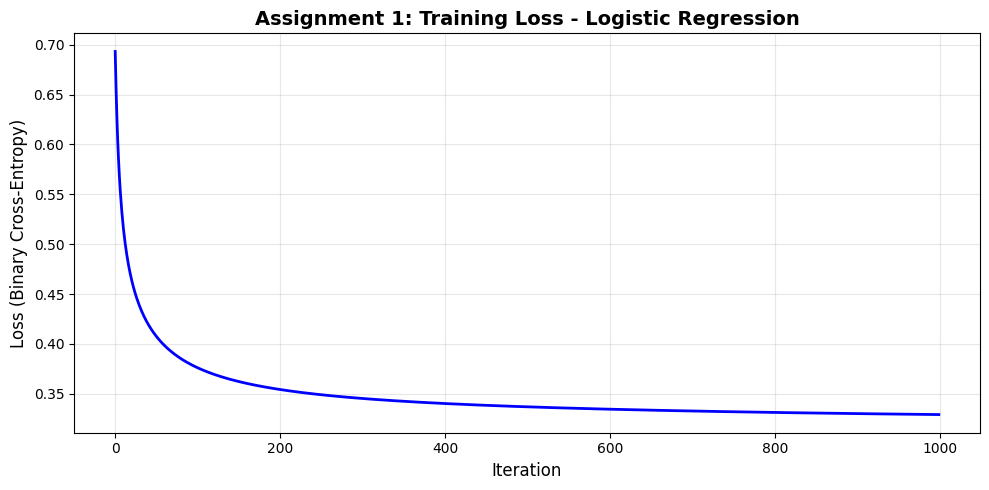

Initial Loss: 0.6931
Final Loss: 0.3292


In [530]:
plt.figure(figsize=(10, 5))
plt.plot(model_lr.losses, linewidth=2, color='blue')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (Binary Cross-Entropy)', fontsize=12)
plt.title('Assignment 1: Training Loss - Logistic Regression', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Loss: {model_lr.losses[0]:.4f}")
print(f"Final Loss: {model_lr.losses[-1]:.4f}")



#### Step 5: Evaluate Model

In [531]:
# Predictions
y_train_pred_bin = model_lr.predict(X_train_bin)
y_test_pred_bin = model_lr.predict(X_test_bin)

# Metrics
train_acc_bin = accuracy_score(y_train_bin, y_train_pred_bin)
test_acc_bin = accuracy_score(y_test_bin, y_test_pred_bin)

print("="*60)
print("ASSIGNMENT 1 - LOGISTIC REGRESSION RESULTS")
print("="*60)
print(f"Training Accuracy: {train_acc_bin:.4f} ({train_acc_bin*100:.2f}%)")
print(f"Test Accuracy: {test_acc_bin:.4f} ({test_acc_bin*100:.2f}%)")
print("\nTest Set Classification Report:")
print(classification_report(y_test_bin, y_test_pred_bin,
                          target_names=['Non-graduate', 'Graduate']))

ASSIGNMENT 1 - LOGISTIC REGRESSION RESULTS
Training Accuracy: 0.8522 (85.22%)
Test Accuracy: 0.8237 (82.37%)

Test Set Classification Report:
              precision    recall  f1-score   support

Non-graduate       0.86      0.77      0.81       443
    Graduate       0.79      0.88      0.83       442

    accuracy                           0.82       885
   macro avg       0.83      0.82      0.82       885
weighted avg       0.83      0.82      0.82       885



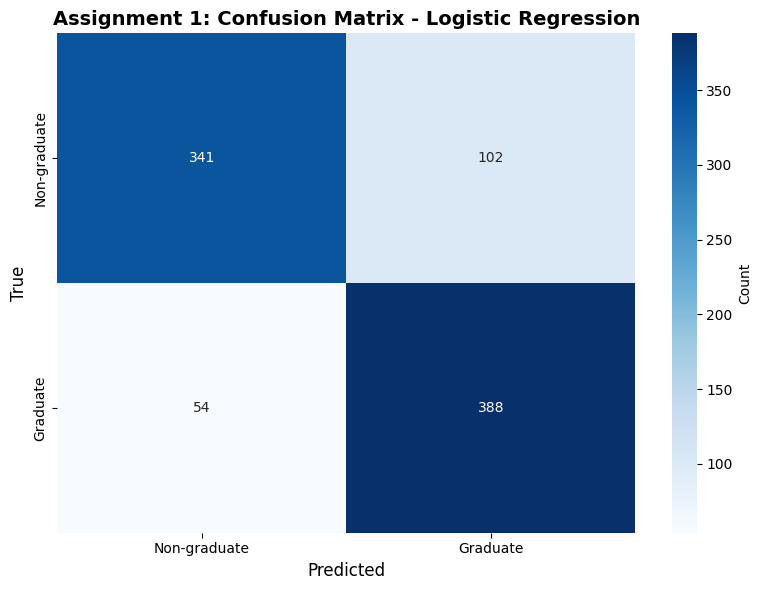

In [532]:
# Confusion Matrix
cm_bin = confusion_matrix(y_test_bin, y_test_pred_bin)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_bin, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-graduate', 'Graduate'],
            yticklabels=['Non-graduate', 'Graduate'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Assignment 1: Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Assignment 2 (4 scores):

- Use Numpy only to construct the Sofmax Regression model.
- Train that Logistic Regression model dataset using the Gradient Descend approach on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Evaluate that Logistic Regression model on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Visualize the loss function of the training process.

#### Step 1: Data Preprocessing

In [533]:
# Keep all 3 classes: Dropout, Enrolled, Graduate
data_multi = data.copy()
label_map = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
data_multi['Target'] = data_multi['Target'].map(label_map)

X_multi = data_multi.drop('Target', axis=1).values
y_multi = data_multi['Target'].values

print(f"Multi-class classification:")
print(f"  Features: {X_multi.shape}")
print(f"  Classes: {np.unique(y_multi)}")
print(f"  Distribution: {np.bincount(y_multi)}")

Multi-class classification:
  Features: (4424, 36)
  Classes: [0 1 2]
  Distribution: [1421  794 2209]


In [534]:
# Normalize
X_multi_norm, mean_multi, std_multi = z_score_normalize(X_multi)

# Train-test split
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_norm, y_multi, test_size=0.2, random_state=42, stratify=y_multi
)

print(f"Train: {X_train_multi.shape[0]}, Test: {X_test_multi.shape[0]}")

Train: 3539, Test: 885


#### Step 2: Build Softmax Regression Model

In [535]:
class SoftmaxRegressionGD:
    def __init__(self, n_classes=3):
        self.n_classes = n_classes
        self.weights = None
        self.bias = None
        self.losses = []
        self.lr = None
        self.epochs = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def one_hot_encode(self, y):
        m = len(y)
        one_hot = np.zeros((m, self.n_classes))
        one_hot[np.arange(m), y] = 1
        return one_hot

    def compute_loss(self, y_true_onehot, y_pred):
        m = len(y_true_onehot)
        epsilon = 1e-15
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        return -1/m * np.sum(y_true_onehot * np.log(y_pred))

    def fit(self, X, y, epochs: int, lr: float):
        self.lr = lr
        self.epochs = epochs

        m, n = X.shape
        self.weights = np.zeros((n, self.n_classes))
        self.bias = np.zeros(self.n_classes)

        y_onehot = self.one_hot_encode(y)

        self.losses = [] # Reset losses for each fit

        for i in range(self.epochs):
            # Forward
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.softmax(z)

            # Loss
            loss = self.compute_loss(y_onehot, y_pred)
            self.losses.append(loss)

            # Gradients
            dw = (1/m) * np.dot(X.T, (y_pred - y_onehot))
            db = (1/m) * np.sum(y_pred - y_onehot, axis=0)

            # Update
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            if (i + 1) % 200 == 0:
                print(f"  Iteration {i+1}/{self.epochs}, Loss: {loss:.4f}")

    def predict_proba(self, X):
        z = np.dot(X, self.weights) + self.bias
        return self.softmax(z)

    def predict(self, X):
        proba = self.predict_proba(X)
        return np.argmax(proba, axis=1)

print("✓ SoftmaxRegressionGD class defined with flexible fit method")

✓ SoftmaxRegressionGD class defined with flexible fit method


#### Step 3: Train Model

In [536]:
model_softmax = SoftmaxRegressionGD(n_classes=3) # Initialize without lr and n_iter
print("Training Softmax Regression...")
# Now you can specify learning_rate and n_iterations when calling fit
model_softmax.fit(X_train_multi, y_train_multi, epochs=800, lr=0.1)
print("✓ Training completed!")

Training Softmax Regression...
  Iteration 200/800, Loss: 0.5801
  Iteration 400/800, Loss: 0.5685
  Iteration 600/800, Loss: 0.5635
  Iteration 800/800, Loss: 0.5607
✓ Training completed!


#### Step 4: Visualize Loss Function

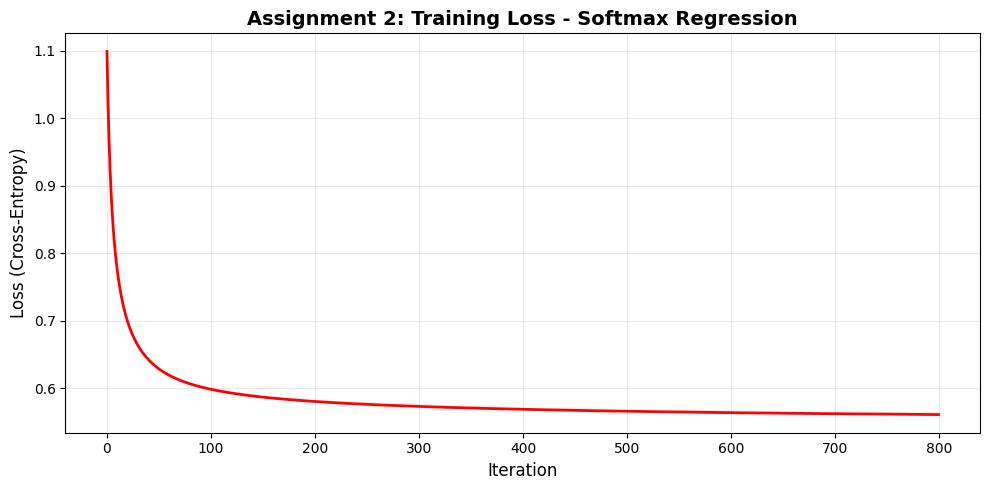

Initial Loss: 1.0986
Final Loss: 0.5607


In [537]:
plt.figure(figsize=(10, 5))
plt.plot(model_softmax.losses, linewidth=2, color='red')
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Loss (Cross-Entropy)', fontsize=12)
plt.title('Assignment 2: Training Loss - Softmax Regression', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Initial Loss: {model_softmax.losses[0]:.4f}")
print(f"Final Loss: {model_softmax.losses[-1]:.4f}")

#### Step 5: Evaluate Model

In [538]:
# Predictions
y_train_pred_multi = model_softmax.predict(X_train_multi)
y_test_pred_multi = model_softmax.predict(X_test_multi)

# Metrics
train_acc_multi = accuracy_score(y_train_multi, y_train_pred_multi)
test_acc_multi = accuracy_score(y_test_multi, y_test_pred_multi)

print("="*60)
print("ASSIGNMENT 2 - SOFTMAX REGRESSION RESULTS")
print("="*60)
print(f"Training Accuracy: {train_acc_multi:.4f} ({train_acc_multi*100:.2f}%)")
print(f"Test Accuracy: {test_acc_multi:.4f} ({test_acc_multi*100:.2f}%)")
print("\nTest Set Classification Report:")
print(classification_report(y_test_multi, y_test_pred_multi,
                          target_names=['Dropout', 'Enrolled', 'Graduate']))

ASSIGNMENT 2 - SOFTMAX REGRESSION RESULTS
Training Accuracy: 0.7731 (77.31%)
Test Accuracy: 0.7740 (77.40%)

Test Set Classification Report:
              precision    recall  f1-score   support

     Dropout       0.82      0.77      0.79       284
    Enrolled       0.55      0.33      0.41       159
    Graduate       0.79      0.94      0.86       442

    accuracy                           0.77       885
   macro avg       0.72      0.68      0.69       885
weighted avg       0.76      0.77      0.76       885



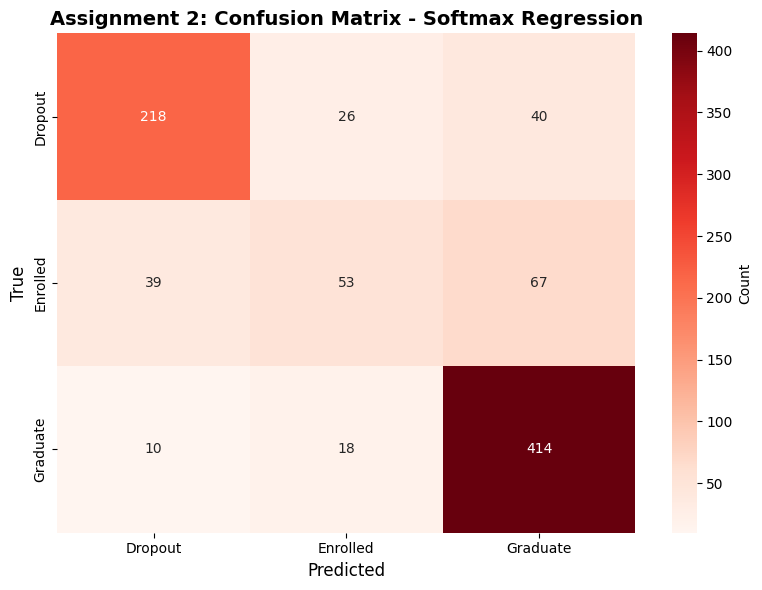

In [539]:
# Confusion Matrix
cm_multi = confusion_matrix(y_test_multi, y_test_pred_multi)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Dropout', 'Enrolled', 'Graduate'],
            yticklabels=['Dropout', 'Enrolled', 'Graduate'],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title('Assignment 2: Confusion Matrix - Softmax Regression', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### Assignment 3 (2 scores):

- Use a Machine Learning library (Scikit Learn or Skorch) to implement and evaluate the Logistic Regression on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.
- Use a Machine Learning library (Scikit Learn or Skorch) to implement and evaluate the Softmax Regression on the [Predict students’ dropout and academic success](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) dataset.

#### 1: Logistic Regression with Scikit-Learn

In [540]:
# Train Logistic Regression
# Learning rate and max_iter are set during initialization for Scikit-learn models
sklearn_lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear') # Using liblinear for binary
sklearn_lr.fit(X_train_bin, y_train_bin)

# Predictions
y_train_pred_sklearn_lr = sklearn_lr.predict(X_train_bin)
y_test_pred_sklearn_lr = sklearn_lr.predict(X_test_bin)

# Metrics
train_acc_sklearn_lr = accuracy_score(y_train_bin, y_train_pred_sklearn_lr)
test_acc_sklearn_lr = accuracy_score(y_test_bin, y_test_pred_sklearn_lr)

print("="*60)
print("ASSIGNMENT 3.1 - SCIKIT-LEARN LOGISTIC REGRESSION")
print("="*60)
print(f"Training Accuracy: {train_acc_sklearn_lr:.4f} ({train_acc_sklearn_lr*100:.2f}%)")
print(f"Test Accuracy: {test_acc_sklearn_lr:.4f} ({test_acc_sklearn_lr*100:.2f}%)")
print("\nTest Set Classification Report:")
print(classification_report(y_test_bin, y_test_pred_sklearn_lr,
                          target_names=['Non-graduate', 'Graduate']))

ASSIGNMENT 3.1 - SCIKIT-LEARN LOGISTIC REGRESSION
Training Accuracy: 0.8550 (85.50%)
Test Accuracy: 0.8237 (82.37%)

Test Set Classification Report:
              precision    recall  f1-score   support

Non-graduate       0.87      0.77      0.81       443
    Graduate       0.79      0.88      0.83       442

    accuracy                           0.82       885
   macro avg       0.83      0.82      0.82       885
weighted avg       0.83      0.82      0.82       885



#### 2: Softmax Regression with Scikit-Learn (Multi-class)

In [541]:
# Train Softmax Regression (multi_class='multinomial')
# Learning rate and max_iter are set during initialization for Scikit-learn models
sklearn_softmax = LogisticRegression(max_iter=1000, multi_class='multinomial',
                                     solver='lbfgs', random_state=42) # lbfgs is suitable for multinomial
sklearn_softmax.fit(X_train_multi, y_train_multi)

# Predictions
y_train_pred_sklearn_soft = sklearn_softmax.predict(X_train_multi)
y_test_pred_sklearn_soft = sklearn_softmax.predict(X_test_multi)

# Metrics
train_acc_sklearn_soft = accuracy_score(y_train_multi, y_train_pred_sklearn_soft)
test_acc_sklearn_soft = accuracy_score(y_test_multi, y_test_pred_sklearn_soft)

print("="*60)
print("ASSIGNMENT 3.2 - SCIKIT-LEARN SOFTMAX REGRESSION")
print("="*60)
print(f"Training Accuracy: {train_acc_sklearn_soft:.4f} ({train_acc_sklearn_soft*100:.2f}%)")
print(f"Test Accuracy: {test_acc_sklearn_soft:.4f} ({test_acc_sklearn_soft*100:.2f}%)")
print("\nTest Set Classification Report:")
print(classification_report(y_test_multi, y_test_pred_sklearn_soft,
                          target_names=['Dropout', 'Enrolled', 'Graduate']))

ASSIGNMENT 3.2 - SCIKIT-LEARN SOFTMAX REGRESSION
Training Accuracy: 0.7734 (77.34%)
Test Accuracy: 0.7684 (76.84%)

Test Set Classification Report:
              precision    recall  f1-score   support

     Dropout       0.79      0.77      0.78       284
    Enrolled       0.52      0.33      0.41       159
    Graduate       0.80      0.93      0.86       442

    accuracy                           0.77       885
   macro avg       0.71      0.68      0.68       885
weighted avg       0.75      0.77      0.75       885



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


---
### SUMMARY
---

FINAL RESULTS COMPARISON


,Model,Task,Train Accuracy,Test Accuracy
0,Assignment 1: Logistic (NumPy),Binary (2 classes),0.8522,0.8237
1,Assignment 2: Softmax (NumPy),Multi-class (3 classes),0.7731,0.7740
2,Assignment 3.1: Logistic (Sklearn),Binary (2 classes),0.8550,0.8237
3,Assignment 3.2: Softmax (Sklearn),Multi-class (3 classes),0.7734,0.7684


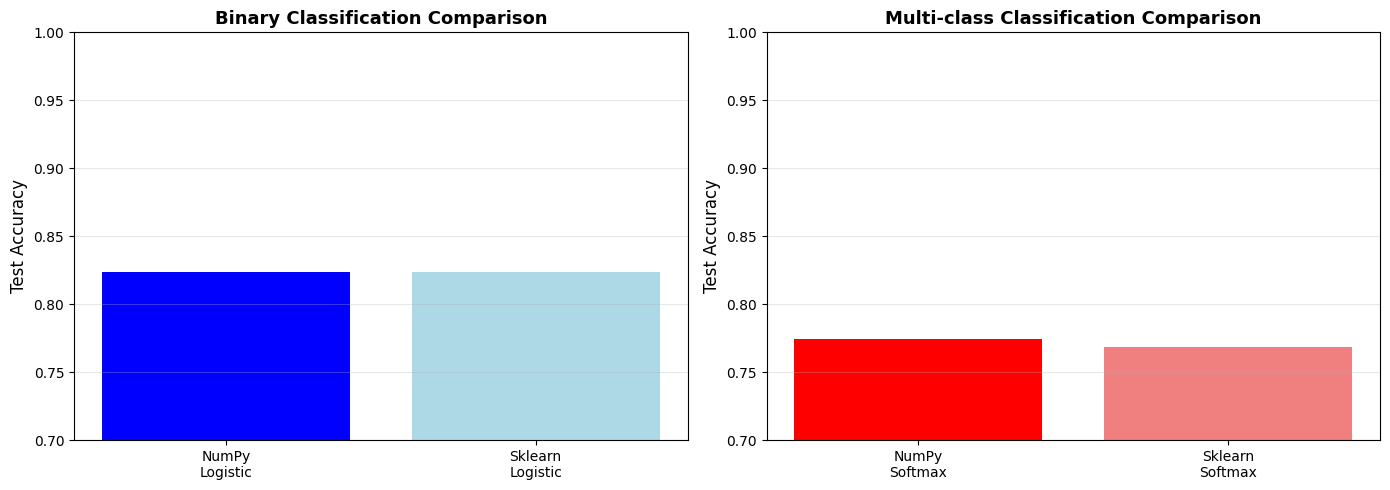

In [542]:
# Compare all models
results = pd.DataFrame({
    'Model': [
        'Assignment 1: Logistic (NumPy)',
        'Assignment 2: Softmax (NumPy)',
        'Assignment 3.1: Logistic (Sklearn)',
        'Assignment 3.2: Softmax (Sklearn)'
    ],
    'Task': [
        'Binary (2 classes)',
        'Multi-class (3 classes)',
        'Binary (2 classes)',
        'Multi-class (3 classes)'
    ],
    'Train Accuracy': [
        f'{train_acc_bin:.4f}',
        f'{train_acc_multi:.4f}',
        f'{train_acc_sklearn_lr:.4f}',
        f'{train_acc_sklearn_soft:.4f}'
    ],
    'Test Accuracy': [
        f'{test_acc_bin:.4f}',
        f'{test_acc_multi:.4f}',
        f'{test_acc_sklearn_lr:.4f}',
        f'{test_acc_sklearn_soft:.4f}'
    ]
})

print("="*80)
print("FINAL RESULTS COMPARISON")
print("="*80)
display(results)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Binary comparison
axes[0].bar(['NumPy\nLogistic', 'Sklearn\nLogistic'],
           [test_acc_bin, test_acc_sklearn_lr],
           color=['blue', 'lightblue'])
axes[0].set_ylabel('Test Accuracy', fontsize=12)
axes[0].set_title('Binary Classification Comparison', fontsize=13, fontweight='bold')
axes[0].set_ylim([0.7, 1.0])
axes[0].grid(axis='y', alpha=0.3)

# Multi-class comparison
axes[1].bar(['NumPy\nSoftmax', 'Sklearn\nSoftmax'],
           [test_acc_multi, test_acc_sklearn_soft],
           color=['red', 'lightcoral'])
axes[1].set_ylabel('Test Accuracy', fontsize=12)
axes[1].set_title('Multi-class Classification Comparison', fontsize=13, fontweight='bold')
axes[1].set_ylim([0.7, 1.0])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()